# Linear Regression on Premier League Players' Salaries

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Data Check and Clean

In [23]:
premleague_df = pd.read_csv('premleague_salary_stats_edited.csv', index_col = 'index')

In [24]:
def editsomemore(dataframe):
    '''
    input: dataframe
    output: dataframe with final data check and clean
    '''
    #dropping players whose salaries were not available
    dataframe = dataframe[dataframe['Annual_Salary(GBP)'].notna()]
    
    #dropping unneded column
    dataframe.drop(columns=['Unnamed: 0', 'MP', 'Min', 'ShotonTarget', 'DribPl'], inplace=True)
    
    return dataframe

In [25]:
premleague = editsomemore(premleague_df)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
premleague.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384 entries, sean longstaff to mesut ozil
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Starts              384 non-null    float64
 1   Gls                 384 non-null    float64
 2   Ast                 384 non-null    float64
 3   TotPassCmp          384 non-null    float64
 4   Prog                384 non-null    float64
 5   Touches_Att3rd      384 non-null    float64
 6   DribSucc            384 non-null    float64
 7   Rec                 384 non-null    float64
 8   Annual_Salary(GBP)  384 non-null    float64
dtypes: float64(9)
memory usage: 30.0+ KB


In [27]:
premleague.describe()

,Starts,Gls,Ast,TotPassCmp,Prog,Touches_Att3rd,DribSucc,Rec,Annual_Salary(GBP)
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,3.840000e+02
mean,18.020833,2.395833,1.710938,669.585938,73.596354,279.776042,15.341146,666.750000,3.493973e+06
std,11.908028,3.960587,2.441436,548.833297,70.622492,289.222776,19.369858,521.647666,2.613635e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000e+04
25%,7.750000,0.000000,0.000000,220.000000,18.000000,41.750000,2.000000,241.750000,1.820000e+06
50%,18.000000,1.000000,1.000000,562.000000,53.000000,190.500000,9.000000,582.500000,2.704000e+06
75%,29.000000,3.000000,2.000000,970.000000,108.000000,434.500000,22.000000,976.250000,4.680000e+06
max,38.000000,22.000000,15.000000,2793.000000,322.000000,1673.000000,143.000000,2612.000000,1.820000e+07


## Visualizing Data

In [28]:
premleague.corr()

,Starts,Gls,Ast,TotPassCmp,Prog,Touches_Att3rd,DribSucc,Rec,Annual_Salary(GBP)
Starts,1.000000,0.403294,0.419971,0.771537,0.641144,0.545597,0.451874,0.780588,0.225590
Gls,0.403294,1.000000,0.544884,0.157999,0.265640,0.628193,0.600946,0.356378,0.400817
Ast,0.419971,0.544884,1.000000,0.370164,0.586977,0.780603,0.585676,0.506992,0.315190
TotPassCmp,0.771537,0.157999,0.370164,1.000000,0.825388,0.518165,0.310117,0.963778,0.290237
Prog,0.641144,0.265640,0.586977,0.825388,1.000000,0.747722,0.463827,0.848903,0.247688
Touches_Att3rd,0.545597,0.628193,0.780603,0.518165,0.747722,1.000000,0.784778,0.674398,0.357521
DribSucc,0.451874,0.600946,0.585676,0.310117,0.463827,0.784778,1.000000,0.486504,0.262870
Rec,0.780588,0.356378,0.506992,0.963778,0.848903,0.674398,0.486504,1.000000,0.359648
Annual_Salary(GBP),0.225590,0.400817,0.315190,0.290237,0.247688,0.357521,0.262870,0.359648,1.000000


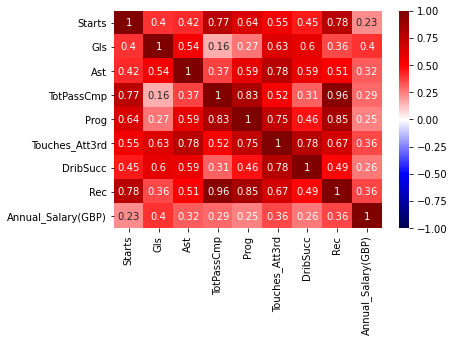

In [29]:
sns.heatmap(premleague.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1);

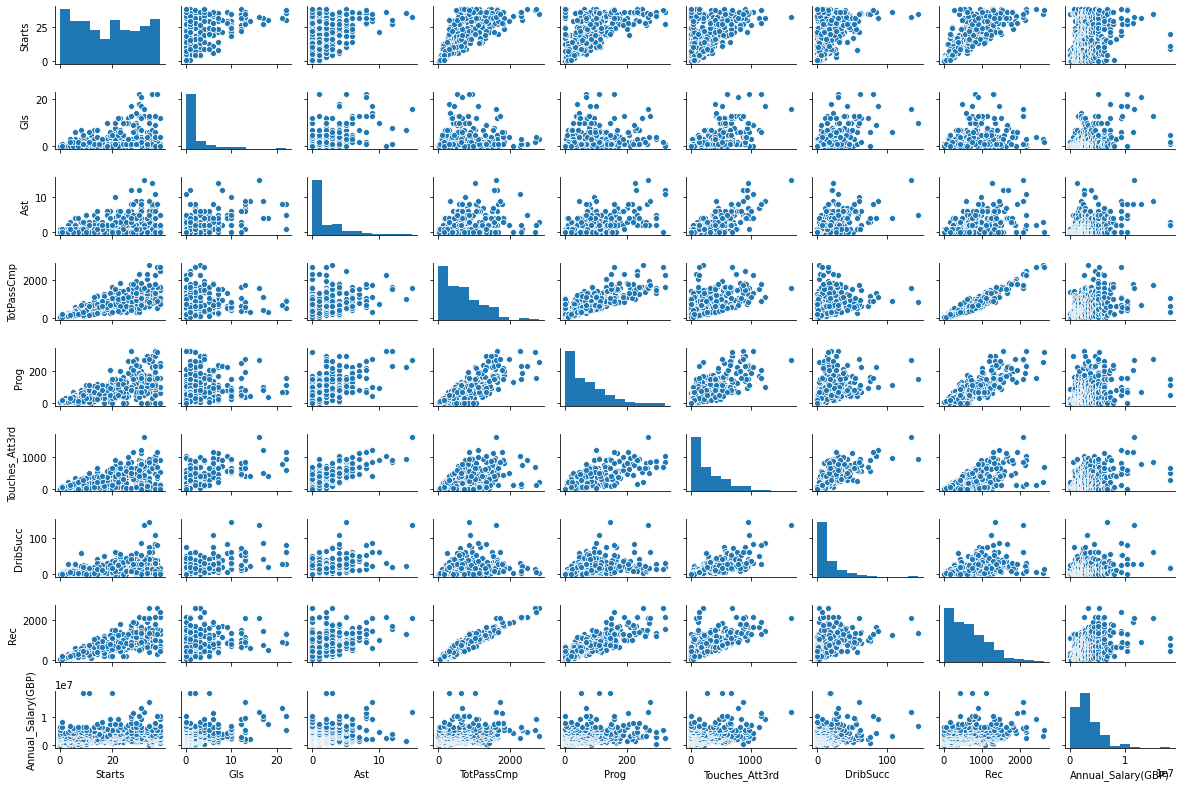

In [30]:
sns.pairplot(premleague, height=1.2, aspect=1.5);

# Modeling

## Cross-Validation / Test

In [36]:
from sklearn.model_selection import KFold

X, y = premleague.drop('Annual_Salary(GBP)',axis=1), premleague['Annual_Salary(GBP)']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [37]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.23352045322427262, 0.0942168270642385, 0.32831159709785684, -0.10988979118352193, 0.38256606062912835]
Ridge scores:  [0.2435087647284676, 0.10198047059050575, 0.32490719449558114, -0.1255528006602189, 0.37365258608676355] 

Simple mean cv r^2: 0.186 +- 0.177
Ridge mean cv r^2: 0.184 +- 0.180
